# Random Forest Model interpretation

In [1]:
%load_ext autoreload
%autoreload 2

In [265]:
%matplotlib inline

from fastai.imports import *
from fastai.structured import *
from pandas_summary import DataFrameSummary
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from IPython.display import display
from sklearn import metrics

In [165]:
set_plot_sizes(12,14,16)

## Load in our data from last lesson

In [213]:
PATH = "data/bulldozers/"

df_raw = pd.read_feather('tmp/raw')
df_trn, y_trn = proc_df(df_raw, 'SalePrice')

In [214]:
def split_vals(a,n): return a[:n], a[n:]
n_valid = 12000
n_trn = len(df_trn)-n_valid
X_train, X_valid = split_vals(df_trn, n_trn)
y_train, y_valid = split_vals(y_trn, n_trn)
raw_train, raw_valid = split_vals(df_raw, n_trn)

In [87]:
def print_score(m):
    res = [m.score(X_train, y_train), m.score(X_valid, y_valid)]
    if hasattr(m, 'oob_score_'): res.append(m.oob_score_)
    print(res)

# Confidence based on tree variance

For model interpretation, there's no need to use the full dataset on each tree - using a subset will be both faster, and also provide better interpretability (since an overfit model will not provide much variance across trees).

In [101]:
set_rf_samples(50000)

In [102]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.90473376259123772, 0.87803611138743476, 0.88708777016194651]


We saw how the model averages predictions across the trees to get an estimate - but how can we know the confidence of the estimate? One simple way is to use the standard deviation of predictions, instead of just the mean. This tells us the *relative* confidence of predictions - that is, for rows where the trees give very different results, you would want to be more cautious of using those results, compared to cases where they are more consistent. Using the same example as in the last lesson when we looked at bagging:

In [103]:
%time preds = np.stack([t.predict(X_valid) for t in m.estimators_])
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 1.17 s, sys: 44 ms, total: 1.21 s
Wall time: 1.22 s


(10575.625, 2380.550996486948)

When we use python to loop through trees like this, we're calculating each in series, which is slow! We can use parallel processing to speed things up:

In [104]:
def get_preds(t): return t.predict(X_valid)
%time preds = np.stack(parallel_trees(m, get_preds))
np.mean(preds[:,0]), np.std(preds[:,0])

CPU times: user 96 ms, sys: 424 ms, total: 520 ms
Wall time: 721 ms


(10575.625, 2380.550996486948)

We can see that different trees are giving different estimates this this auction. In order to see how prediction confidence varies, we can add this into our dataset.

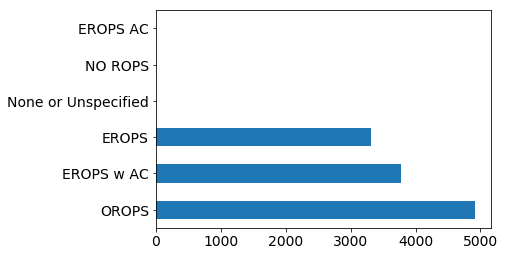

In [106]:
x = raw_valid.copy()
x['pred_std'] = np.std(preds, axis=0)
x['pred'] = np.mean(preds, axis=0)
x.Enclosure.value_counts().plot.barh();

In [107]:
flds = ['Enclosure', 'SalePrice', 'pred', 'pred_std']
enc_summ = x[flds].groupby('Enclosure', as_index=False).mean()
enc_summ

,Enclosure,SalePrice,pred,pred_std
0,EROPS,23832.088875,23787.728297,6921.972081
1,EROPS AC,NaN,NaN,NaN
2,EROPS w AC,48859.438708,47731.921676,11414.552277
3,NO ROPS,NaN,NaN,NaN
4,None or Unspecified,NaN,NaN,NaN
5,OROPS,19740.942398,19743.888572,4727.199171


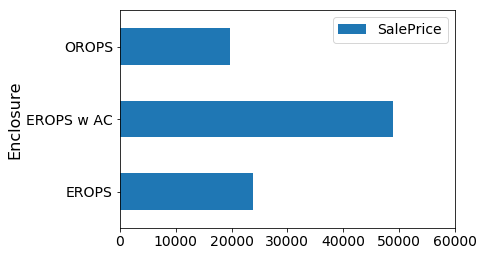

In [108]:
enc_summ = enc_summ[~pd.isnull(enc_summ.SalePrice)]
enc_summ.plot('Enclosure', 'SalePrice', 'barh', xlim=(0,60000));

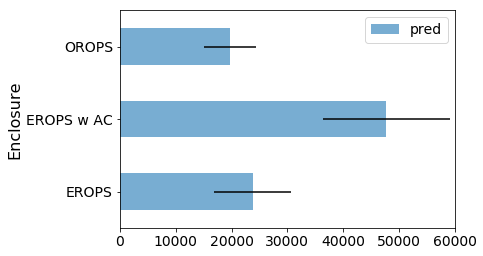

In [109]:
enc_summ.plot('Enclosure', 'pred', 'barh', xerr='pred_std', alpha=0.6, xlim=(0,60000));

*Question*: Why are the predictions nearly exactly right, but the error bars are quite wide?

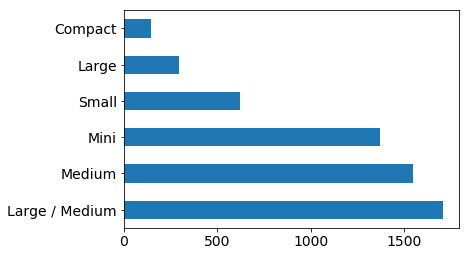

In [110]:
raw_valid.ProductSize.value_counts().plot.barh();

In [112]:
flds = ['ProductSize', 'SalePrice', 'pred', 'pred_std']
summ = x[flds].groupby(flds[0]).mean()
summ

,SalePrice,pred,pred_std
ProductSize,,,
Compact,18644.055944,21372.023633,7609.287317
Large,44233.501684,41419.807348,14178.606963
Large / Medium,50743.053927,49868.314494,12919.956815
Medium,50882.343447,49252.174067,12573.621157
Mini,15071.767714,15847.894603,4517.560531
Small,35009.214744,35691.011237,10418.719055


In [113]:
(summ.pred_std/summ.pred).sort_values(ascending=False)

ProductSize
Compact           0.356040
Large             0.342315
Small             0.291914
Mini              0.285057
Large / Medium    0.259081
Medium            0.255291
dtype: float64

# Feature importance

It's not normally enough to just to know that a model can make accurate predictions - we also want to know *how* it's making predictions. The most important way to see this is with *feature importance*.

In [114]:
fi = rf_feat_importance(m, df_trn); fi[:10]

,cols,imp
5,YearMade,0.185543
13,ProductSize,0.142519
19,Enclosure,0.089677
10,fiSecondaryDesc,0.078194
55,saleElapsed,0.062854
14,fiProductClassDesc,0.048072
2,ModelID,0.046531
8,fiModelDesc,0.041509
12,fiModelDescriptor,0.029567
0,SalesID,0.028536


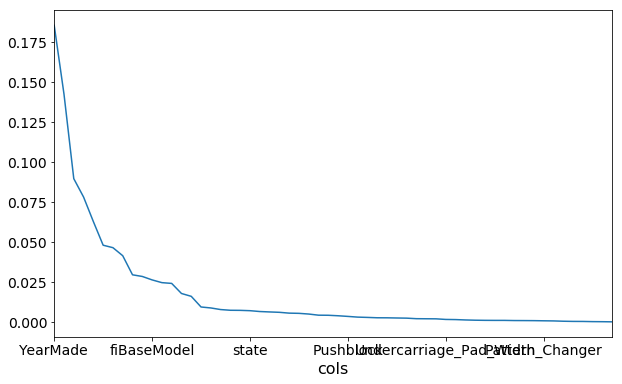

In [115]:
fi.plot('cols', 'imp', figsize=(10,6), legend=False);

In [116]:
def plot_fi(fi): return fi.plot('cols', 'imp', 'barh', figsize=(12,7), legend=False)

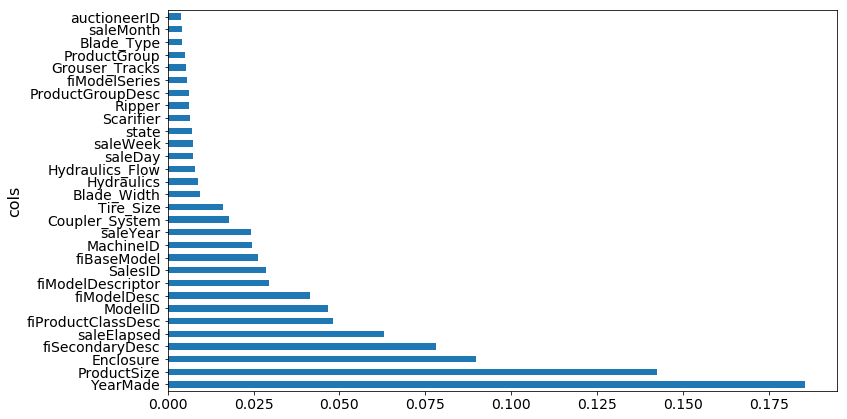

In [117]:
plot_fi(fi[:30]);

In [118]:
to_keep = fi[fi.imp>0.005].cols; len(to_keep)

27

In [119]:
df_keep = df_trn[to_keep].copy()
X_train, X_valid = split_vals(df_keep, n_trn)

In [120]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5,
                          n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.90351088575576466, 0.87709417123373923, 0.88643524023956644]


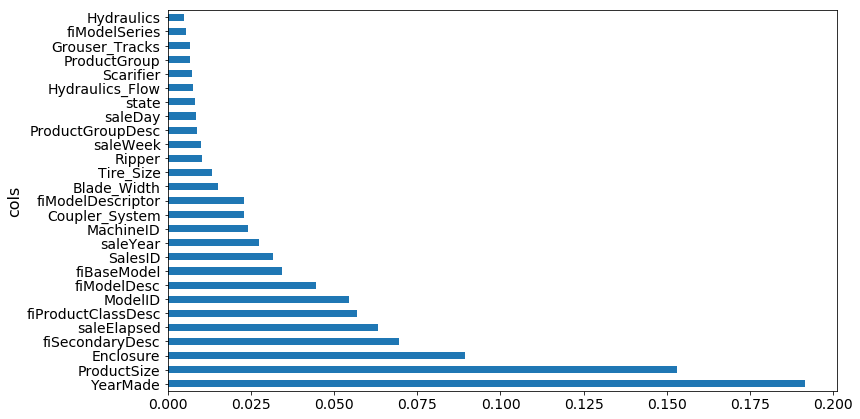

In [121]:
fi = rf_feat_importance(m, df_keep)
plot_fi(fi);

In [122]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.90455251387035418, 0.88061939783930954, 0.88753655844110402]


## One-hot encoding

In [123]:
df_trn2, y_trn = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)

m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.90262808686985141, 0.87259100119771538, 0.88423224432886049]


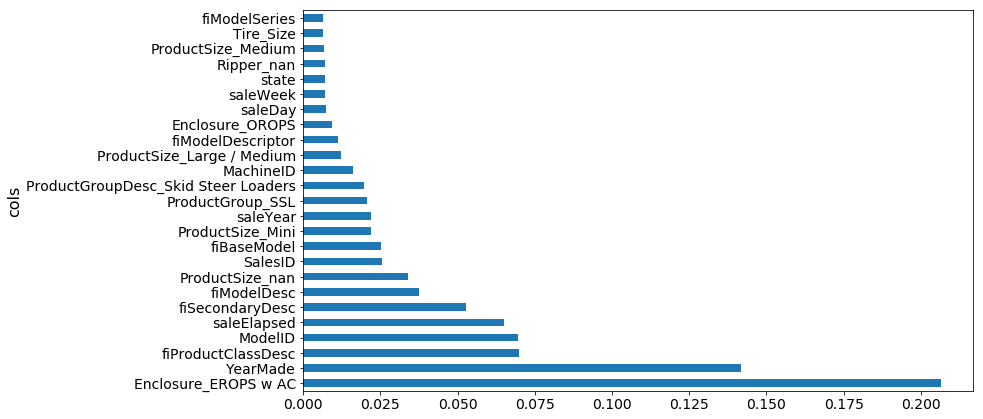

In [124]:
fi = rf_feat_importance(m, df_trn2)
plot_fi(fi[:25]);

# Removing redundant features

One thing that makes this harder to interpret is that there seem to be some variables with very similar meanings. Let's try to remove redundent features.

In [137]:
from scipy.cluster import hierarchy as hc

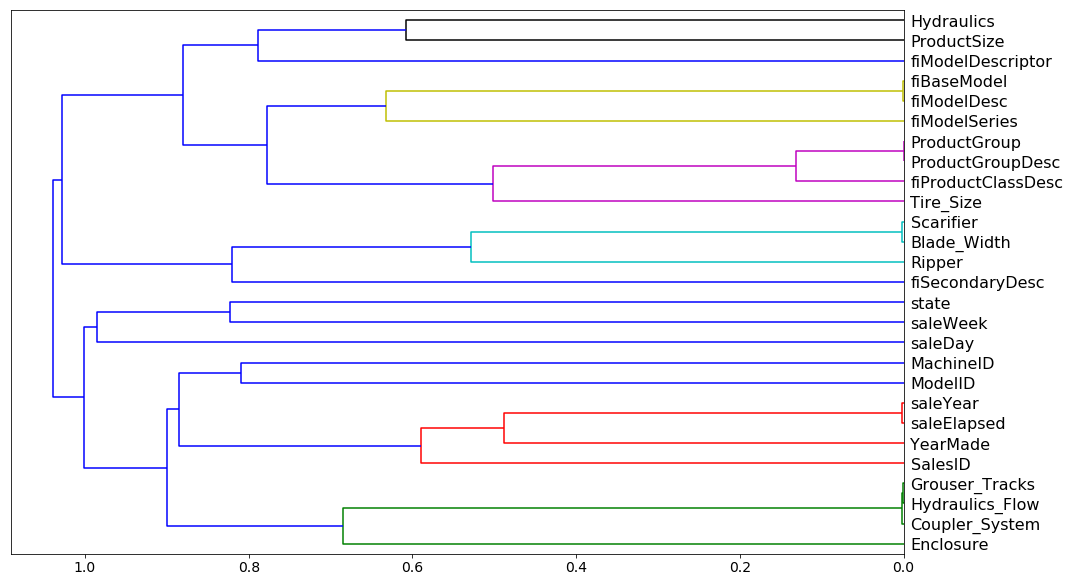

In [138]:
corr = np.round(scipy.stats.spearmanr(df_keep).correlation, 4)
corr_condensed = hc.distance.squareform(1-corr)
z = hc.linkage(corr_condensed, method='average')
fig = plt.figure(figsize=(16,10))
dendrogram = hc.dendrogram(z, labels=df_keep.columns, orientation='left', leaf_font_size=16)
plt.show()

Let's try removing some of these related features to see if the model can be simplified without impacting the accuracy.

In [140]:
def get_oob(df):
    m = RandomForestRegressor(n_estimators=30, min_samples_leaf=5, max_features=0.6, n_jobs=-1, oob_score=True)
    x, _ = split_vals(df, n_trn)
    m.fit(x, y_train)
    return m.oob_score_

Here's our baseline.

In [141]:
get_oob(df_keep)

0.88094911174758728

Now we try removing each variable one at a time.

In [142]:
for c in ('saleYear', 'saleElapsed', 'fiModelDesc', 'fiBaseModel', 'Grouser_Tracks', 'Coupler_System'):
    print(c, get_oob(df_keep.drop(c, axis=1)))

saleYear 0.880242090865
saleElapsed 0.877366768481
fiModelDesc 0.881336212081
fiBaseModel 0.882919629604
Grouser_Tracks 0.880131316989
Coupler_System 0.882019541448


It looks like we can try one from each group for removal. Let's see what that does.

In [143]:
to_drop = ['saleYear', 'fiBaseModel', 'Grouser_Tracks']
get_oob(df_keep.drop(to_drop, axis=1))

0.88133205647305735

Looking good! Let's use this dataframe from here. We'll save the list of columns so we can reuse it later.

In [144]:
df_keep.drop(to_drop, axis=1, inplace=True)
X_train, X_valid = split_vals(df_keep, n_trn)

In [145]:
np.save('tmp/keep_cols.npy', np.array(df_keep.columns))

In [146]:
keep_cols = np.load('tmp/keep_cols.npy')
df_keep = df_trn[keep_cols]

And let's see how this model looks on the full dataset.

In [147]:
reset_rf_samples()

In [148]:
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.96594208683231064, 0.90136854187704685, 0.90729828788594502]


# Partial dependence

In [215]:
from pdpbox import pdp
from plotnine import *

In [ ]:
set_rf_samples(50000)

In [217]:
df_trn2, y_trn = proc_df(df_raw, 'SalePrice', max_n_cat=7)
X_train, X_valid = split_vals(df_trn2, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train);

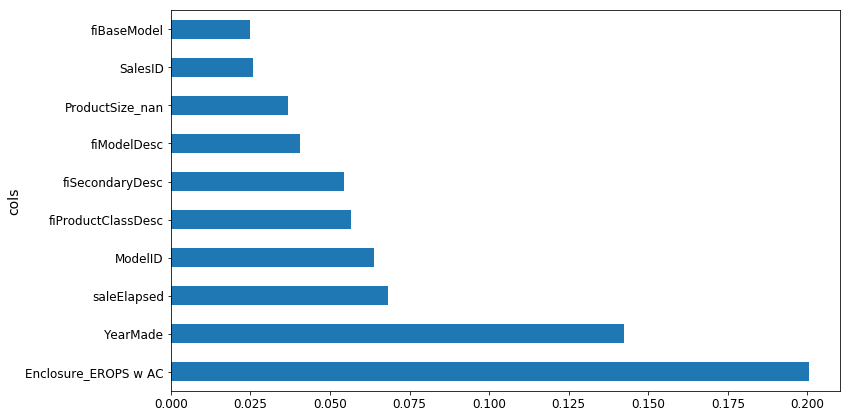

In [218]:
plot_fi(rf_feat_importance(m, df_trn2)[:10]);

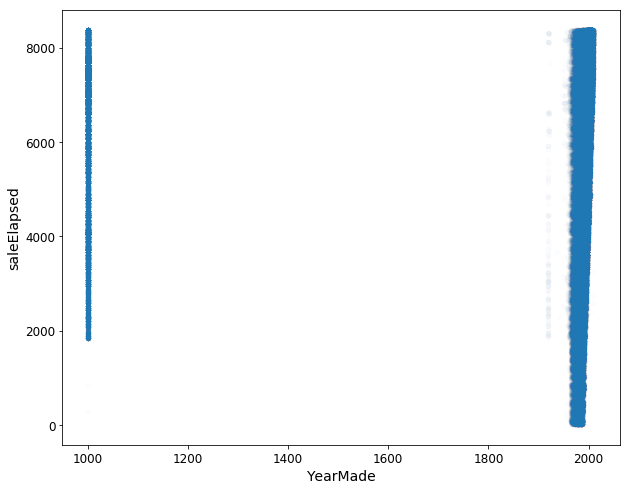

In [219]:
df_raw.plot('YearMade', 'saleElapsed', 'scatter', alpha=0.01, figsize=(10,8));

In [221]:
x_all = get_sample(df_raw[df_raw.YearMade>1930], 500)

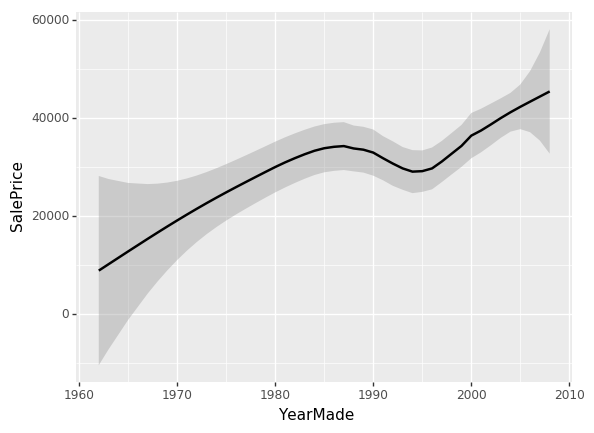

<ggplot: (8762557349219)>

In [222]:
ggplot(x_all, aes('YearMade', 'SalePrice'))+stat_smooth(se=True, method='loess')

In [223]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

In [244]:
def plot_pdp(feat, clusters=None, feat_name=None):
    feat_name = feat_name or feat
    p = pdp.pdp_isolate(m, x, feat)
    return pdp.pdp_plot(p, feat_name, plot_lines=True, 
                        cluster=clusters is not None, n_cluster_centers=clusters)

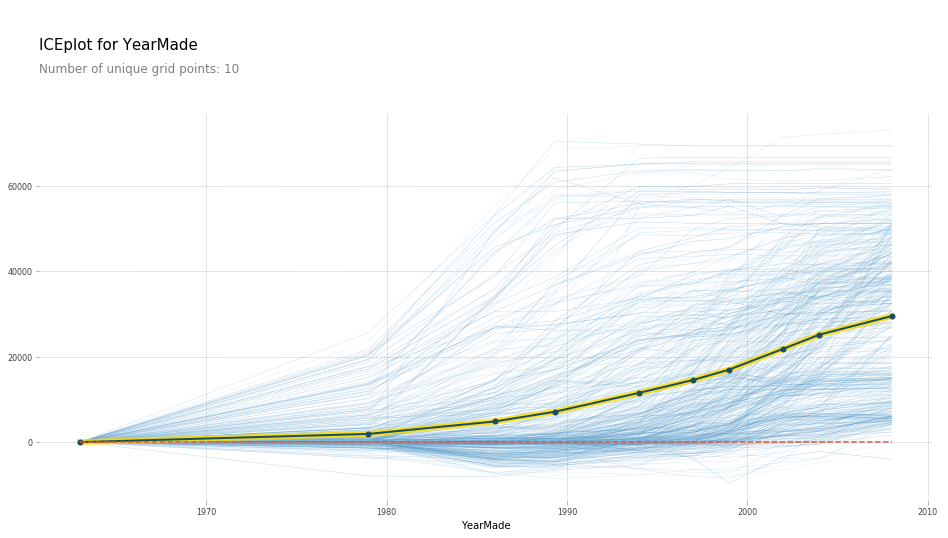

In [245]:
plot_pdp('YearMade')

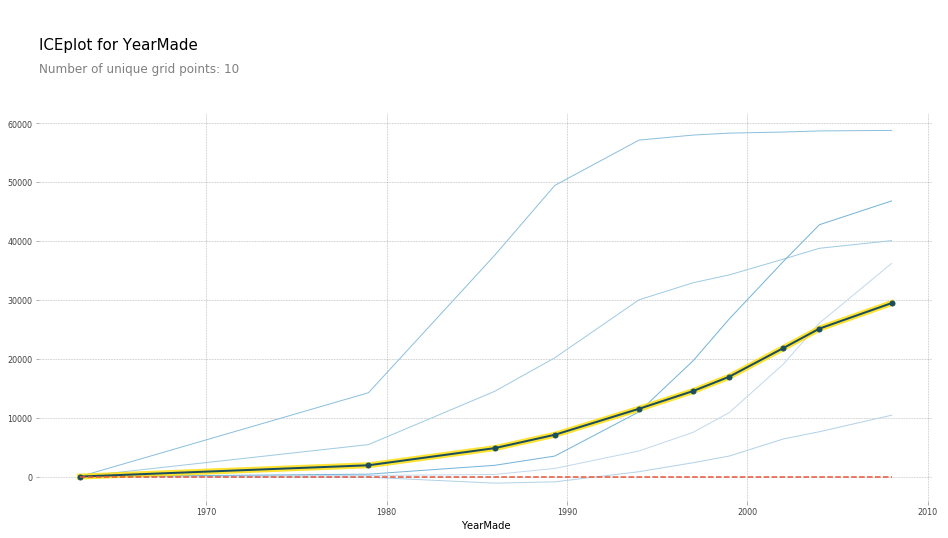

In [232]:
plot_pdp('YearMade', clusters=5)

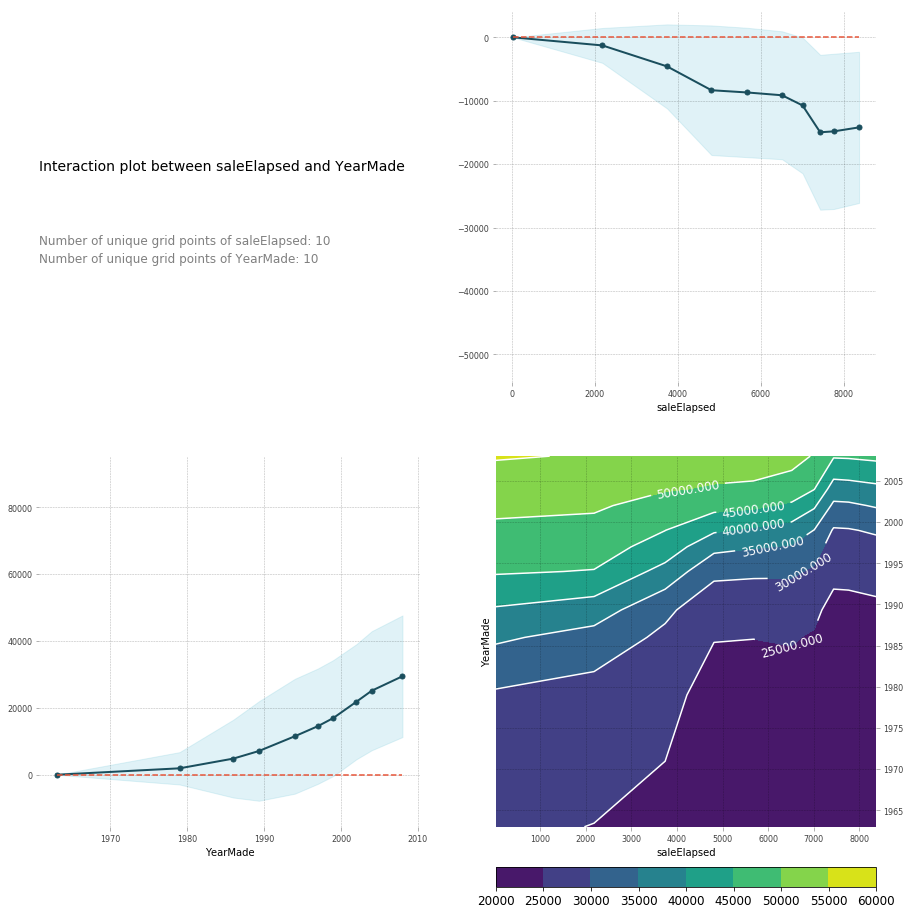

In [233]:
feats = ['saleElapsed', 'YearMade']
p = pdp.pdp_interact(m, x, feats)
pdp.pdp_interact_plot(p, feats)

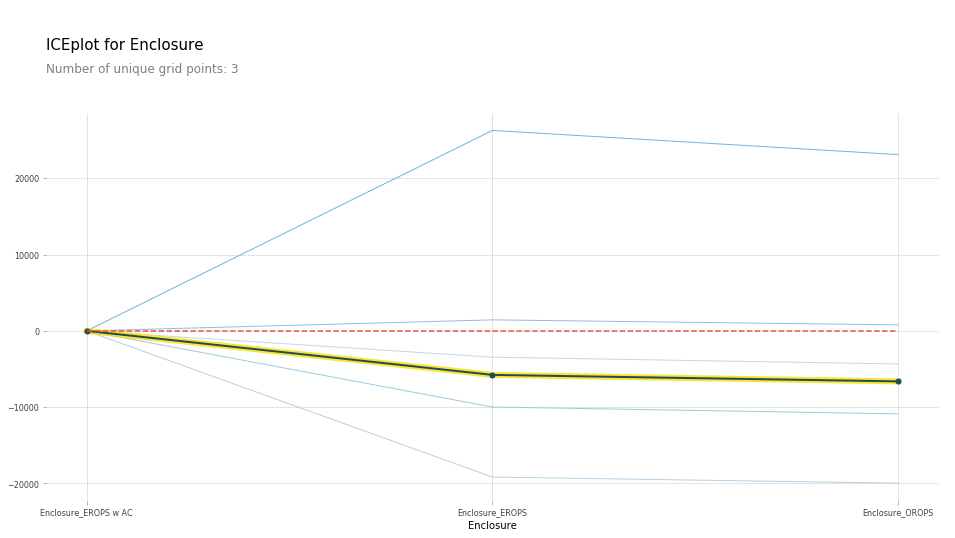

In [246]:
plot_pdp(['Enclosure_EROPS w AC', 'Enclosure_EROPS', 'Enclosure_OROPS'], 5, 'Enclosure')

In [251]:
df_keep['age'] = df_raw['age'] = df_raw.saleYear-df_raw.YearMade

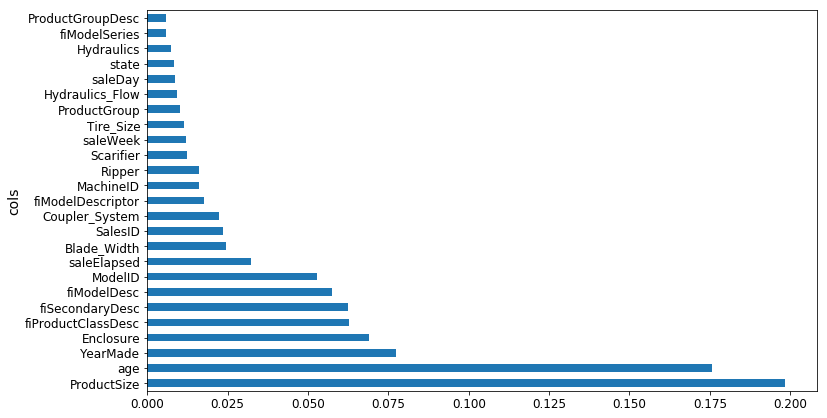

In [248]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.6, n_jobs=-1)
m.fit(X_train, y_train)
plot_fi(rf_feat_importance(m, df_keep));

# Tree interpreter

In [252]:
from treeinterpreter import treeinterpreter as ti

In [253]:
df_train, df_valid = split_vals(df_raw[df_keep.columns], n_trn)

In [255]:
row = X_valid.values[None,0]; row

array([[   1999,       4,       0,      -1,    7912,      16,     665,    3231,      -1, 4364751,
        2300944,      -1,      -1,      -1,      11,      -1,      16,      37,      34,      -1,
             -1,       3,      62,       3,      11]])

In [256]:
prediction, bias, contributions = ti.predict(m, row)

In [257]:
prediction[0], bias[0]

(11034.184523809523, 31133.073741499997)

In [262]:
[o for o in zip(df_keep.columns, df_valid.iloc[0], sorted(contributions[0]))]

[('YearMade', 1999, -10081.640036349982),
 ('ProductSize', 'Mini', -4826.86464677809),
 ('Enclosure', 'EROPS', -3289.4061249032675),
 ('fiSecondaryDesc', nan, -1043.8136260288991),
 ('saleElapsed', 7912, -951.34354258577935),
 ('fiProductClassDesc',
  'Hydraulic Excavator, Track - 3.0 to 4.0 Metric Tons',
  -709.40674361067101),
 ('ModelID', 665, -555.49192032690701),
 ('fiModelDesc', 'KX1212', -401.76717458011171),
 ('fiModelDescriptor', nan, -383.79497274169),
 ('SalesID', 4364751, -330.91642694443834),
 ('MachineID', 2300944, -203.65378520036012),
 ('Coupler_System', nan, -152.49887621554973),
 ('Tire_Size', nan, -129.85129391764235),
 ('Blade_Width', nan, -59.216457189418904),
 ('Hydraulics', 'Standard', -27.441120839340101),
 ('Hydraulics_Flow', nan, 0.0),
 ('saleDay', 16, 0.0),
 ('saleWeek', 37, 0.0),
 ('state', 'Ohio', 64.303520670067655),
 ('Scarifier', nan, 75.949847907344562),
 ('Ripper', nan, 78.197713915538586),
 ('ProductGroupDesc', 'Track Excavators', 248.04311743439501),

In [802]:
contributions[0].sum()

-20121.445139124971

# Extrapolation

In [279]:
df_ext = df_ext.copy()
df_ext['is_valid'] = 1
df_ext.is_valid[:n_trn] = 0
x, y = proc_df(df_ext, 'is_valid')

In [268]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

In [270]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
9,SalesID,0.744765
4,saleElapsed,0.174639
10,MachineID,0.067977
7,fiModelDesc,0.003321
6,ModelID,0.002377
2,Enclosure,0.001395
0,YearMade,0.001346
17,saleWeek,0.001142
11,Coupler_System,0.000936
15,Hydraulics_Flow,0.000789


In [289]:
feats=['SalesID', 'saleElapsed', 'MachineID']

In [280]:
x.drop(feats, axis=1, inplace=True)

In [281]:
m = RandomForestClassifier(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(x, y);
m.oob_score_

0.97831100031162355

In [282]:
fi = rf_feat_importance(m, x); fi[:10]

,cols,imp
21,age,0.235574
0,YearMade,0.189105
14,saleWeek,0.135826
5,ModelID,0.082095
13,saleDay,0.065709
6,fiModelDesc,0.061375
15,state,0.054998
4,fiProductClassDesc,0.035539
3,fiSecondaryDesc,0.023549
2,Enclosure,0.022350


In [284]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1)
m.fit(X_train, y_train);

In [287]:
x = get_sample(X_train[X_train.YearMade>1930], 500)

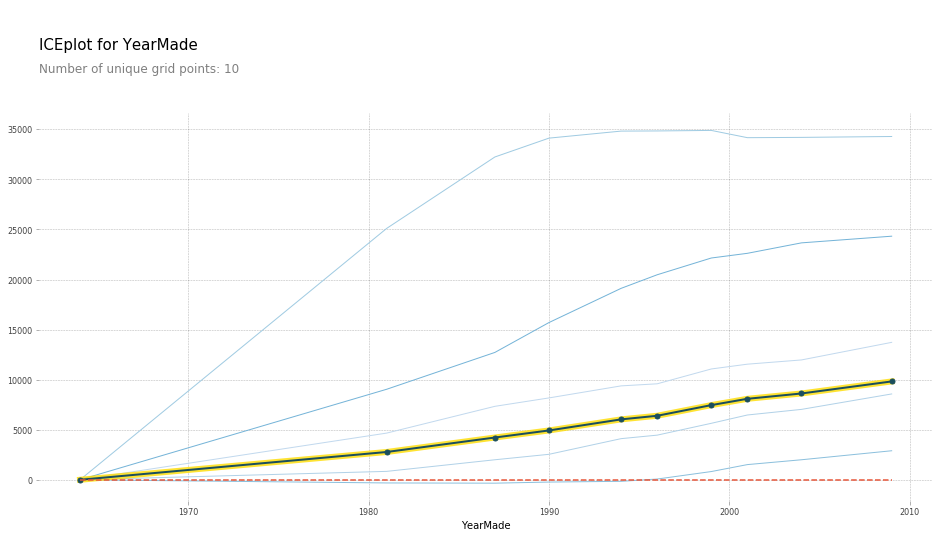

In [291]:
plot_pdp('YearMade', clusters=5)

In [295]:
(X_train[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,389125.000000,389125.000000,389125.000000
mean,1800.452485,5.599522,1206.796148
std,595.627288,2.087862,430.850552
min,1139.246000,0.000000,0.000000
25%,1413.348000,4.232000,1087.016000
50%,1632.093000,6.176000,1273.859000
75%,2210.453000,7.328000,1458.661000
max,4364.741000,8.381000,2313.821000


In [296]:
(X_valid[feats]/1000).describe()

,SalesID,saleElapsed,MachineID
count,12000.000000,12000.000000,12000.000000
mean,5786.967651,8.166793,1578.049709
std,836.899608,0.289098,589.497173
min,4364.751000,6.638000,0.830000
25%,4408.580750,8.197000,1271.225250
50%,6272.538500,8.276000,1825.317000
75%,6291.792250,8.338000,1907.858000
max,6333.342000,8.382000,2486.330000


In [299]:
set_rf_samples(50000)

In [302]:
X_train, X_valid = split_vals(df_keep, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.90607541953248028, 0.87827221547711498, 0.88865504934667805]


In [308]:
for f in feats:
    df_subs = df_keep.drop(f, axis=1)
    X_train, X_valid = split_vals(df_subs, n_trn)
    m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
    m.fit(X_train, y_train)
    print(f)
    print_score(m)

SalesID
[0.9048702264651447, 0.87854082091319508, 0.88790950110409783]
saleElapsed
[0.89840219159359747, 0.86953109757515956, 0.87997639180746412]
MachineID
[0.90818103477352674, 0.88388230436637716, 0.89198237545863113]


In [311]:
reset_rf_samples()

In [314]:
df_subs = df_keep.drop(['SalesID', 'MachineID'], axis=1)
X_train, X_valid = split_vals(df_subs, n_trn)
m = RandomForestRegressor(n_estimators=40, min_samples_leaf=3, max_features=0.5, n_jobs=-1, oob_score=True)
m.fit(X_train, y_train)
print_score(m)

[0.96204610714276995, 0.90700384195214989, 0.90976994380988863]


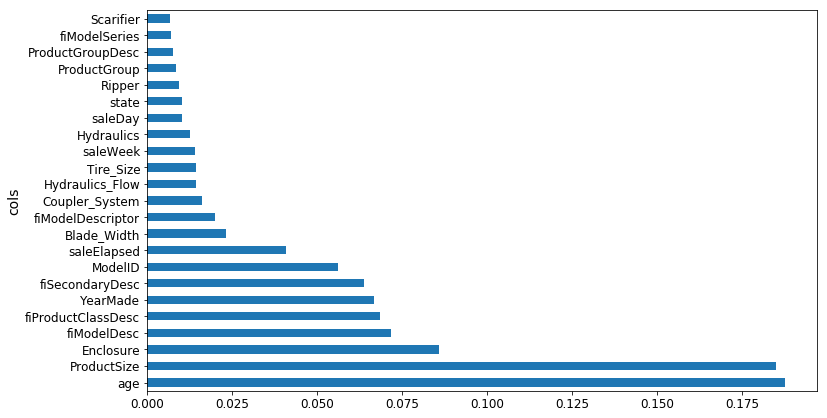

In [313]:
plot_fi(rf_feat_importance(m, X_train));